In [1]:
import itertools
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Functions

In [2]:
def clean_data(raw, z_threshold=2.5, min_listen_time=20):
    """
    Drops entries with abnormal listening_time (z-score too high or time too low).
    Also removes entries with unknown origin
    :param min_listen_time: entries where the user has listened for less than this (s) are dropped
    :param z_threshold: maximum z-score allowed in the dataset
    :param raw: raw data to be processed
    :return: clean dataset (pd.DataFrame)
    """
    print("Computing z-score...")
    z = np.abs(stats.zscore(raw["listening_time"]))

    print("Cleaning...")
    # Entries with a z-score above the threshold will be dropped (also instant-skips of listening_time < X)
    raw.drop(raw[z > z_threshold].index, inplace=True)
    raw.drop(raw[raw.listening_time < min_listen_time].index, inplace=True)
    return raw[(raw["origin"] != "unknown")]

In [3]:
def is_reco(origin):
    return origin[:3] == "rec" or origin == "flow"

In [4]:
def bin_artists(data, bin_amnt=25, separate_reco=True):
    """
    takes in raw data from streams (with added art_id -- see "formatting/add_artists.py") and bins artists together
    according to their "mainstream" status -- i.e. how much they are listened to.
    :param bin_amnt: amount of bins the artists will be put into AT MOST
    :param separate_reco: Whether or not to add a "recommended" column to the DF
    :param data: DataFrame ["user_id", "ts", "sng_id", "album_id", "listening_time", "listen_type", "origin", "art_id"]
    :return: the same DataFrame with added columns [..., "bin_nb", "recommended"] -- unless recommended is not wanted
    """
    print("Counting artist occurences...")
    artist_count = data["art_id"].value_counts(normalize=False).sort_values(ascending=True).to_frame() \
        .reset_index().rename(columns={"index": "art_id", "art_id": "plays"})
    artist_count["cumplays"] = artist_count["plays"].cumsum()

    print("Binning artists...")
    # Cutting into bin_amnt bins (duplicate bins allowed -- and necessary for small datasets and large amount of bins)
    artist_count["bin"] = pd.cut(artist_count["cumplays"], bin_amnt, duplicates="drop")
    print(f"Number of artists per bin: \n{artist_count.groupby('bin').size()}")

    # Assigning corresponding numbers to bins
    artist_count["bin_nb"] = (artist_count["bin"].cat.codes + 1).values
    print(f"Artists binned into {artist_count['bin_nb'].max()} categories.")

    data = data.merge(artist_count[["art_id", "bin_nb"]], left_on="art_id", right_on="art_id")

    # Adding 'recommended' column
    if separate_reco:
        data["recommended"] = data["origin"].map(is_reco)

    return data

In [5]:
def get_user_frame(data, bin_distribution):
    # Vectorized computing of the users' bin ratios
    user_frame = main_dist.to_frame()
    user_frame.columns = ["ratio"]

    # Our user_frame ends up with [user, bin_nb, ratio]
    user_plays = user_frame["ratio"].sum(level=0)
    user_frame = user_frame.unstack('bin_nb').divide(bin_distrib, level=1).divide(user_plays, axis=0).stack("bin_nb")

    user_frame = user_frame.reset_index()
    
    return user_frame

In [6]:
FILE_NAME = "../../data/artist_streams.csv"
SAVE_NAME = "../../data/mainstream_data.csv"
MIN_OBS = 100
SEPARATE_RECO = False
BIN_AMNT = 4

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("darkgrid")

In [7]:
print("Reading data...")
raw_data = pd.read_csv(FILE_NAME)
# raw_data = clean_data(raw_data, z_threshold=3)
print(f"Data shape: {raw_data.shape[0]} lines, {raw_data.shape[1]} columns")

Reading data...
Data shape: 2242117 lines, 8 columns


In [8]:
# Bin artists together
artist_data = bin_artists(raw_data, BIN_AMNT, SEPARATE_RECO)

print(f"Standard deviation of amount of plays per bin: {np.std(artist_data.groupby(['bin_nb']).size().values)}")

Counting artist occurences...
Binning artists...
Number of artists per bin: 
bin
(-2241.116, 560530.0]     8342
(560530.0, 1121059.0]      443
(1121059.0, 1681588.0]     138
(1681588.0, 2242117.0]      45
dtype: int64
Artists binned into 4 categories.
Standard deviation of amount of plays per bin: 1200.0225779125992


In [9]:
# Occurences of music plays in each bin
bin_distrib = artist_data.groupby("bin_nb").size()

# Reversing bin numbers -- just a dirty little workaround to have the "mainstreamest" bin be 1
artist_data["bin_nb"] = BIN_AMNT+1 - artist_data["bin_nb"]

# Normalized
bin_distrib /= bin_distrib.sum()

In [13]:
# Why does this need to be here? Didn't I do that somewhere else?
artist_data["recommended"] = artist_data["origin"].map(is_reco)

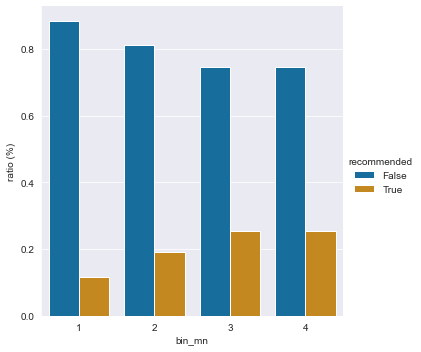

In [14]:
# Computing % of recommended to organic plays in each mainstream bin
bin_plays = artist_data.groupby(['bin_nb']).size().to_frame().reset_index()
bin_plays_doubled = pd.DataFrame(np.repeat(bin_plays.values,2,axis=0))
bin_plays_doubled.columns = bin_plays.columns
bin_plays_rec = artist_data.groupby(["bin_nb", "recommended"]).size().to_frame().reset_index()
bin_plays_rec[0] = bin_plays_rec[0].divide(bin_plays_doubled[0])

ax = sns.catplot(x="bin_nb", y=0, hue="recommended", palette="colorblind", data=bin_plays_rec, kind="bar")
ax.set(xlabel="bin_mn", ylabel="ratio (%)")
plt.savefig("../../results/reco_ratio_per_binmn.pdf")

In [15]:
# Grouping users and their artist bin consumption
main_dist = artist_data.groupby(["user_id", "recommended", "bin_nb"] if SEPARATE_RECO
                                else ["user_id", "bin_nb"]).size()

print(f"Removing users with fewer than {MIN_OBS} observations...")
remove_idx = artist_data.groupby(["user_id"]).size()
remove_idx = remove_idx[remove_idx < MIN_OBS].index.unique()

main_dist.drop(labels=remove_idx, inplace=True)
print(f"Removed {len(remove_idx)} users.")

Removing users with fewer than 100 observations...
Removed 5 users.


In [ ]:
print("Analyzing users...")
test_users = np.random.choice(main_dist.index.get_level_values("user_id").unique(), 6, replace=False)
recommended_choices = [True, False]
aggregate = pd.DataFrame(columns=["user_id", "recommended", "bin_nb", "ratio"])

# Users pre-binning based on recommendation usage

In [16]:
# Determining rate of recommended to organic for users
artist_data["recommended"] = artist_data["origin"].map(is_reco)
users_reco = artist_data.groupby(["user_id", "recommended"]).size().reset_index()
users_reco.columns = ["user_id", "recommended", "amnt"]

# Checking if all users have both types before division
users_reco_types = users_reco.groupby(["user_id"]).size()
users_reco_types = list(users_reco_types[users_reco_types == 1].index)

# Adding True column for False-only users and vice-versa
to_add = users_reco[users_reco["user_id"].isin(users_reco_types)]
to_add.loc[:, "recommended"] = ~to_add["recommended"]
# Not using 0 to avoid divisions -- in practice, this won't affect the bins
to_add.loc[:, "amnt"] = 1
users_reco = users_reco.append(to_add).sort_values(by=["user_id"])

users_reco.loc[:, "rate"] = 0
rec_amnts = users_reco[users_reco["recommended"] == True]["amnt"].values
org_amnts = users_reco[users_reco["recommended"]== False]["amnt"].values

# Changing users_reco into the final DataFrame
users_reco = users_reco[users_reco.recommended == True].drop(["recommended", "amnt"], axis=1)
users_reco.loc[:, "rate"] = rec_amnts / (rec_amnts + org_amnts)

# Adding nb of plays to users_reco in order to form bins with equal amounts of plays
users_reco = main_dist.groupby("user_id").sum().to_frame().merge(users_reco, left_on="user_id", right_on="user_id").sort_values("rate", ascending=True)
users_reco["cumplays"] = users_reco[0].cumsum()
users_reco

c:\users\quentin\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,user_id,0,rate,cumplays
1010,fd61d2e5c20dfd623ff7567de8d48554e1999287,3369,0.000297,3369
475,772454490ca8d33ffbd714e1b7614fd9f4940ecb,3221,0.000310,6590
39,0a0100d31aafde83997be544a0ef1f717ca9694f,3121,0.000320,9711
62,11176609b069e51fefa6f924c88f6f3f9f1057a3,3058,0.000327,12769
758,b9115fc11d1a49ca11b1eff5d3d21dd96ed12720,3012,0.000332,15781
...,...,...,...,...
791,c39c70f6e297f9526190c5ea8325726427e9f338,5761,0.931262,2234464
126,2600ac94a475cf35303616de09d915c740a67386,2453,0.937627,2236917
18,0670ca9e7c4e320a13a0495ee5558dd2dbd6f4d6,1839,0.965198,2238756
209,39610b7c24ff424b8f242aa4f13da6765717f877,1600,0.973125,2240356


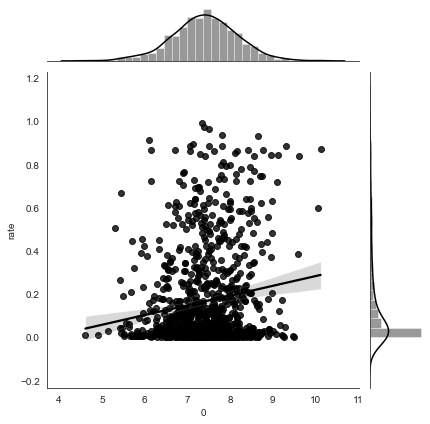

In [17]:
with sns.axes_style("white"):
    sns.jointplot(x=np.log(users_reco[0]), y="rate", data=users_reco, kind="reg", color="k");

Number of users per bin: 
u_bin
(1130.471, 563001.25]      269
(563001.25, 1122633.5]     274
(1122633.5, 1682265.75]    283
(1682265.75, 2241898.0]    192
dtype: int64
Users binned into 4 categories.


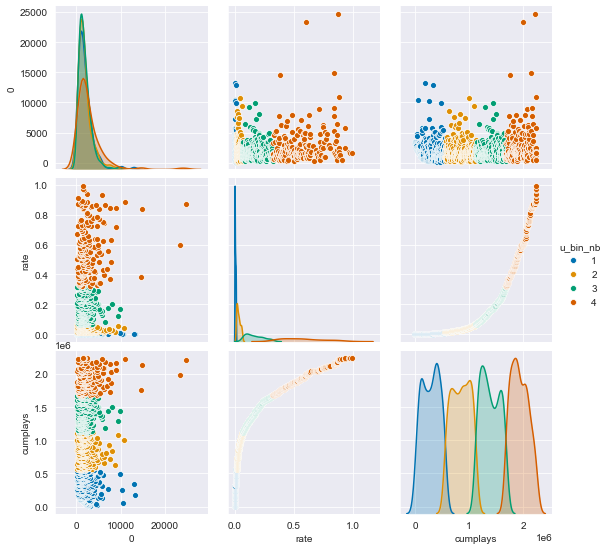

0.05566486189158005
0.013157894736842105
0.06639566395663957


In [18]:
USER_BINS = 4
# Cutting into bins
users_reco["u_bin"] = pd.cut(users_reco["cumplays"], USER_BINS, duplicates="drop")
print(f"Number of users per bin: \n{users_reco.groupby('u_bin').size()}")

# Assigning corresponding numbers to bins
users_reco["u_bin_nb"] = (users_reco["u_bin"].cat.codes + 1).values
print(f"Users binned into {users_reco['u_bin_nb'].max()} categories.")
sns.pairplot(users_reco, hue="u_bin_nb")
plt.show()
print(users_reco["rate"].median())
print(users_reco[users_reco["u_bin_nb"] == 1]["rate"].max())
print(users_reco[users_reco["u_bin_nb"] == 2]["rate"].max())
# print(users_reco[users_reco["u_bin_nb"] == 3]["rate"].max())
# print(users_reco[users_reco["u_bin_nb"] == 4]["rate"].max())

# users_reco[["user_id", "rate", "u_bin_nb"]].to_csv("../../data/user_bins.csv", index=False)
users_reco.drop(["u_bin", "rate"], axis=1, inplace=True)

# sns.distplot(users_reco[users_reco["bin_nb"] == 4]["rate"], kde=False)

In [ ]:
users_reco.groupby("u_bin_nb").size().to_frame().reset_index()

In [11]:
# Amount of plays per user bin
main_dist.groupby("user_id").sum().to_frame().merge(users_reco, left_on="user_id", right_on="user_id").groupby("u_bin_nb").sum()

NameError: name 'main_dist' is not defined

In [14]:
# Testing correctness of user frame ratios
# user_frame = get_user_frame(main_dist, bin_distrib)
# user_frame.groupby("user_id")["ratio"].sum().values.mean()

user_frame = get_user_frame(main_dist, bin_distrib).merge(users_reco, left_on="user_id", right_on="user_id").drop(["user_id"], axis=1)

# Geometric mean
# user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(stats.gmean).to_frame().reset_index()
user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(np.mean).to_frame().reset_index()

print(user_bin_ratios.groupby("u_bin_nb")["ratio"].sum().values.mean())

# Log ratio
user_bin_ratios["ratio"] = user_bin_ratios["ratio"].map(np.log)

4.013059365960039


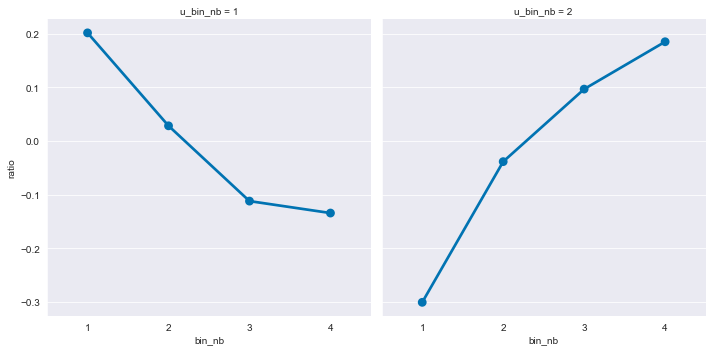

In [15]:
# Plotting the first users
sns.catplot(x="bin_nb", y="ratio", kind="point", col="u_bin_nb", col_wrap=2, data=user_bin_ratios, legend=False)

# Computing bin_distrib -- Vectorized version

In [135]:
user_frame = get_user_frame(main_dist, bin_distrib)

In [186]:
# Saving frame
user_frame.to_csv("mainstream_ratios.csv", index=False)

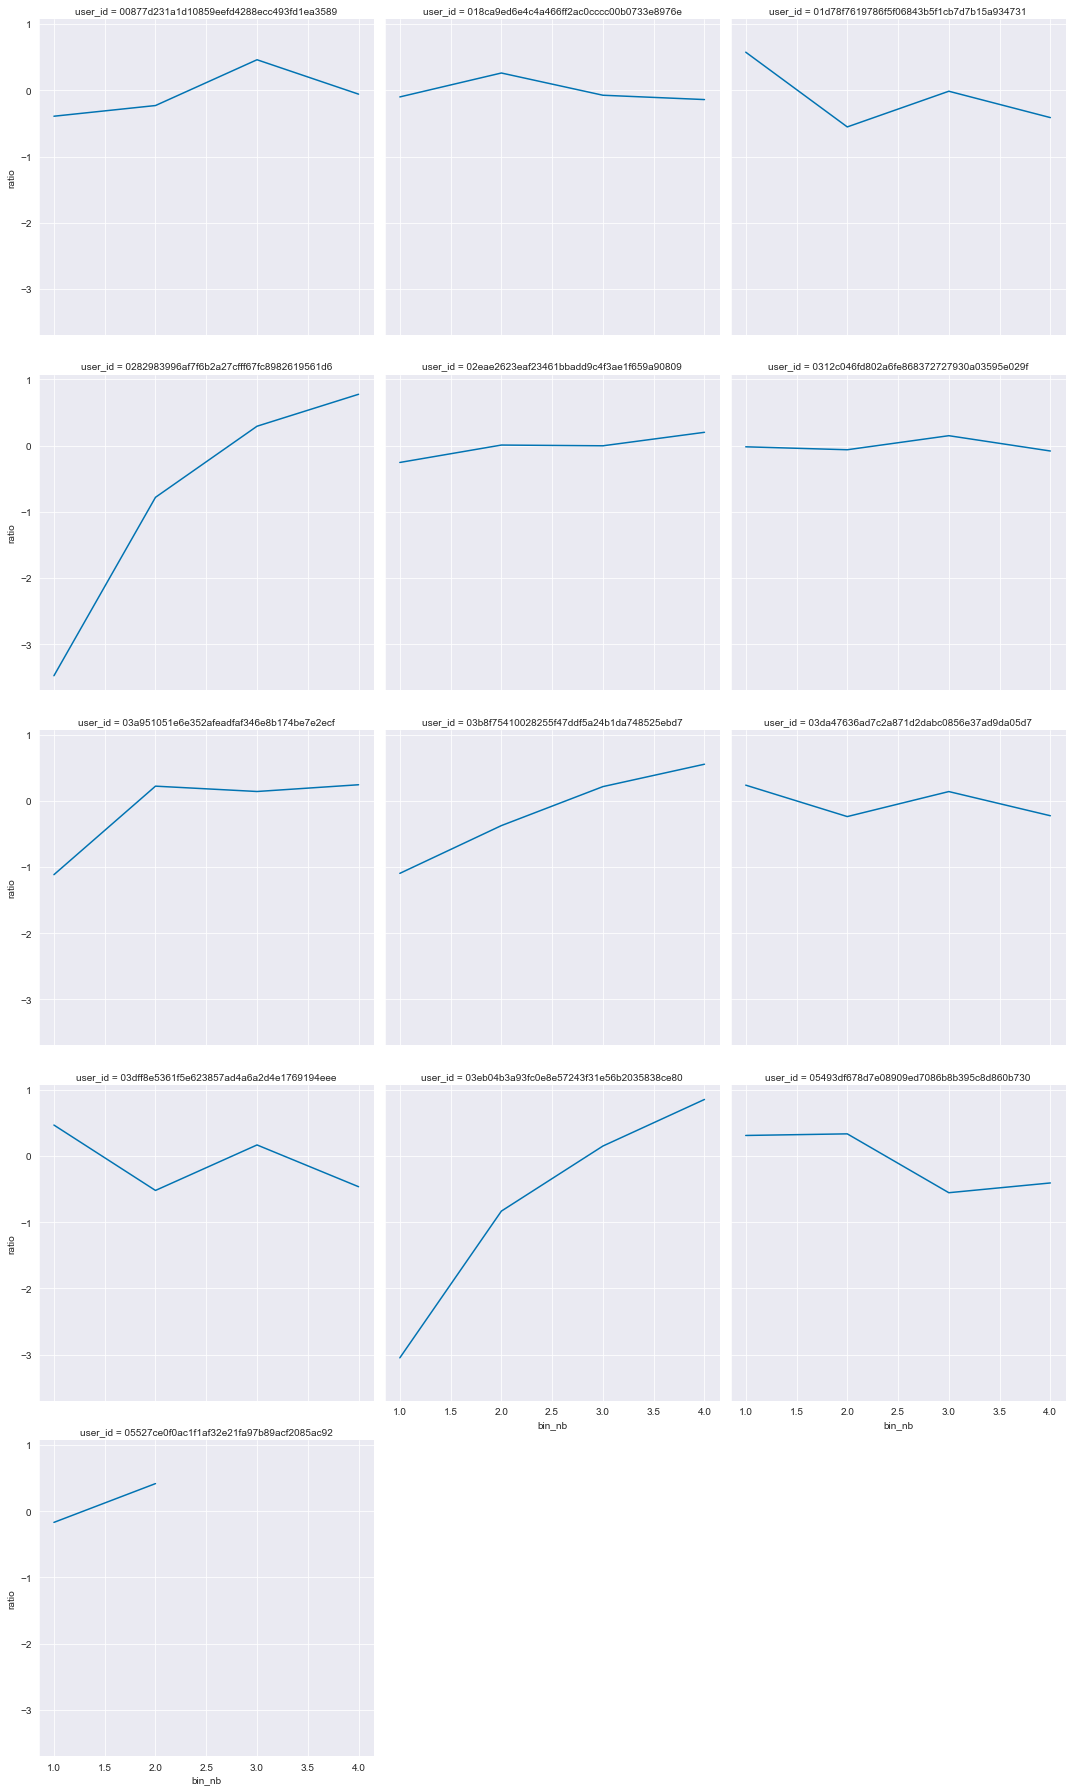

In [136]:
# Log for ratio
user_frame["ratio"] = user_frame["ratio"].map(np.log)

#Plotting the first users
sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
            estimator=None, data=user_frame[:50], legend=False)

# Are recommendations favorizing mainstream content?

In [13]:
reco_mainstream = artist_data.merge(users_reco, left_on="user_id", right_on="user_id").drop(["ts", "listen_type", "listening_time", "album_id", "sng_id", "origin"], axis=1)

# For each user bin (recommendation based grouping)
reco_mainstream = reco_mainstream.groupby(["bin_nb", "u_bin_nb", "recommended"]).size()
reco_mainstream = reco_mainstream.to_frame().reset_index()
reco_mainstream.columns = ["bin_nb", "u_bin_nb", "recommended", "amount"]

# Testing stuff right there -- loop version because I have no idea how to vectorize this for now
test = reco_mainstream.groupby(["u_bin_nb", "recommended"]).mean().reset_index()

reco_mainstream["amount"] = reco_mainstream["amount"].astype(float)

for i, row in reco_mainstream.iterrows():
    reco_mainstream.at[i, "amount"] /= test[(test["u_bin_nb"] == reco_mainstream.at[i, "u_bin_nb"]) & (test["recommended"] == reco_mainstream.at[i, "recommended"])]["amount"]

# Mean mainstream bin for recommended vs. organic
test = reco_mainstream.groupby(["bin_nb", "recommended"])["amount"].sum().to_frame().reset_index()
print(test)
test_org = test[test["recommended"] == False]
test_rec = test[test["recommended"] == True]
print(f'Mean mainstream bin for organic plays: {(test_org["amount"] * test_org["bin_nb"]).sum() / test_org["amount"].sum()}')
print(f'Mean mainstream bin for recommended plays: {(test_rec["amount"] * test_rec["bin_nb"]).sum() / test_rec["amount"].sum()}')

# Log ratio
reco_mainstream["amount"] = reco_mainstream["amount"].map(np.log)
0
reco_mainstream

   bin_nb  recommended    amount
0       1        False  2.143559
1       1         True  1.259599
2       2        False  2.028791
3       2         True  1.854051
4       3        False  1.904522
5       3         True  2.453354
6       4        False  1.923128
7       4         True  2.432996
Mean mainstream bin for organic plays: 2.4509024788991054
Mean mainstream bin for recommended plays: 2.7574682480379185


,bin_nb,u_bin_nb,recommended,amount
0,1,1,False,0.235468
1,1,1,True,-0.245614
2,1,2,False,-0.130043
3,1,2,True,-0.739453
4,2,1,False,0.032275
5,2,1,True,-0.056307
6,2,2,False,-0.004018
7,2,2,True,-0.095629
8,3,1,False,-0.136394
9,3,1,True,0.139346


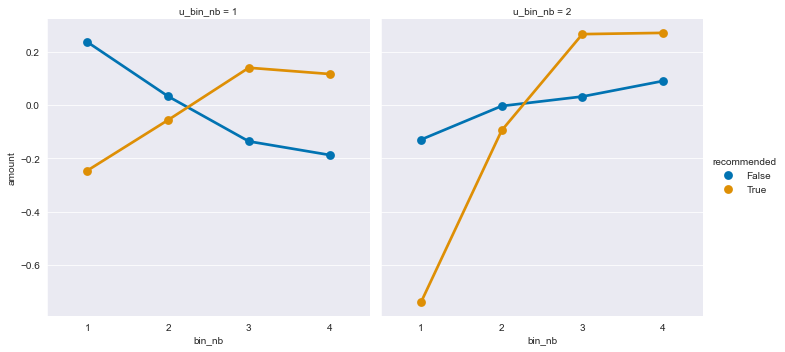

In [17]:
sns.catplot(x="bin_nb", y="amount", col="u_bin_nb", col_wrap=2, hue="recommended", kind="point", data=reco_mainstream)

## Are organic non-mainstream listenings the result of previous recommendations?

In [13]:
# Removing non-valid timestamps (aberrant values and timestamps outside the bulk of the dataset)
truncated_data = artist_data.drop(artist_data[artist_data["ts"] < 1473000000].index)

# Removing the first month of data to try and ensure most of the first listens are actually first listens
min_ts = truncated_data["ts"].min() + 2592000
truncated_data = truncated_data[truncated_data["ts"] > min_ts]


# Finding songs for each user that were listened to only once 
single_listens = truncated_data.groupby(["user_id", "sng_id"]).size()
single_listens = single_listens[single_listens < 2].to_frame().index

# Removing singletons from dataset
# data_no_singletons = (artist_data[~pd.Series(list(zip(artist_data['user_id'], artist_data['sng_id']))).isin(single_listens)])[["user_id", "ts", "sng_id", "recommended"]]
# data_no_singletons = data_no_singletons.reset_index().drop("index", axis=1)
single_listens = truncated_data.groupby(["user_id", "sng_id"]).size()
single_listens = single_listens[single_listens < 2].to_frame().reset_index()[["user_id", "sng_id"]]
single_listens["drop"] = True
data_no_singletons = truncated_data.merge(single_listens, how="left", left_on=["user_id", "sng_id"], right_on=["user_id", "sng_id"])
data_no_singletons = data_no_singletons[data_no_singletons["drop"] != True]
data_no_singletons = data_no_singletons[["user_id", "ts", "sng_id", "recommended"]]

data_no_singletons = data_no_singletons.sort_values(by=["user_id", "ts"]).reset_index().drop("index", axis=1)

data_no_singletons

,user_id,ts,sng_id,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,1475598228,13792835,True
1,00877d231a1d10859eefd4288ecc493fd1ea3589,1475598429,3134033,True
2,00877d231a1d10859eefd4288ecc493fd1ea3589,1475598792,109734566,True
3,00877d231a1d10859eefd4288ecc493fd1ea3589,1475601406,106152016,True
4,00877d231a1d10859eefd4288ecc493fd1ea3589,1475601705,107394234,True
...,...,...,...,...
525831,ff82befb6c2bcf11c638706bc27cf787128426de,1479497155,108692368,False
525832,ff82befb6c2bcf11c638706bc27cf787128426de,1479538385,108692368,False
525833,ff82befb6c2bcf11c638706bc27cf787128426de,1479538643,108692368,False
525834,ff82befb6c2bcf11c638706bc27cf787128426de,1479711552,108692368,False


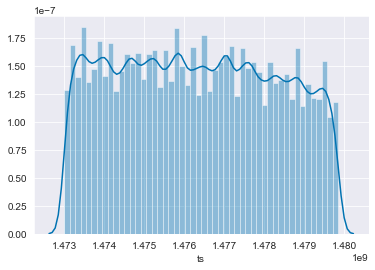

In [24]:
sns.distplot(data_no_singletons["ts"])

In [43]:
# Loop form -- maybe vectorizable at some point?
current_user = ""
user_dict = {}

adopted_table = pd.DataFrame(columns=["user_id", "sng_id", "adopted"])
for i, row in data_no_singletons.iterrows():
    if current_user != row["user_id"]:
        # New user -- soft reset
        current_user = row["user_id"]
        # Adding non-adopted songs (i.e. entries in the dict with a value of zero)
        if not all(user_dict.values()):
            for sng in {x:y for x,y in user_dict.items() if y==0}:
                adopted_table = pd.concat([adopted_table, pd.DataFrame([[current_user, sng, False]], columns=["user_id", "sng_id", "adopted"])],
                                       ignore_index=True)
        user_dict = {}
        
    # Adding entry to dict for first listens
    if row["sng_id"] not in user_dict and row["recommended"]:
        user_dict[row["sng_id"]] = 0

    # Adding to adopted table if adopted
    if row["sng_id"] in user_dict and not row["recommended"]:
        user_dict[row["sng_id"]] += 1
        # Listen type different from the first time
        if (adopted_table[(adopted_table["user_id"] == current_user) & (adopted_table["sng_id"] == row["sng_id"])]).empty:
#             if [current_user, row["sng_id"]] not in adopted_table[adopted_table.columns[:2]].values:
            # Value not yet in the table
            adopted_table = pd.concat([adopted_table, pd.DataFrame([[current_user, row["sng_id"], True]], columns=["user_id", "sng_id", "adopted"])],
                                       ignore_index=True)
                
    if i % 50000 == 0:
        print(i)

adopted_table

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000


,user_id,sng_id,adopted
0,00877d231a1d10859eefd4288ecc493fd1ea3589,857985,True
1,00877d231a1d10859eefd4288ecc493fd1ea3589,106152016,True
2,00877d231a1d10859eefd4288ecc493fd1ea3589,2232655,True
3,00877d231a1d10859eefd4288ecc493fd1ea3589,757085,True
4,00877d231a1d10859eefd4288ecc493fd1ea3589,7045661,True
...,...,...,...
34429,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,908995,False
34430,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,72299954,False
34431,fe8b03dc9d448192808c8cd2bf76657b7562b3ae,70266756,False
34432,fea927761d221701b2bf1b6acc2de6d91d060071,71483067,False


In [44]:
adopted_table.to_csv("adopted_table.csv", index=False)

In [14]:
adopted_table = pd.read_csv("adopted_table.csv")

## Total version

In [62]:
song_bins = artist_data[["sng_id", "bin_nb"]].drop_duplicates().reset_index().drop(["index"], axis=1)

# Adding mainstream bins to adopted_table
adopted_table = adopted_table.merge(song_bins[["sng_id", "bin_nb"]], left_on="sng_id", right_on="sng_id")
adopted_table

,user_id,sng_id,adopted,bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,True,2
1,05493df678d7e08909ed7086b8b395c8d860b730,3599714,False,2
2,06c9e7762c83ab9358c845274eee7be7cd4331b3,3599714,False,2
3,11a1e13499a8ea7303dba477122e8202de8a24bb,3599714,False,2
4,2ad14bc4eb38a15310b0b00b87494a67ed47100d,3599714,False,2
...,...,...,...,...
61217,fe016f7c946213bd53ca9b683b7314d24d2dbba9,76849955,False,4
61218,fe016f7c946213bd53ca9b683b7314d24d2dbba9,73706048,True,4
61219,fe016f7c946213bd53ca9b683b7314d24d2dbba9,62986059,True,4
61220,fe22a3978a595c3a63cb40558db7804956f8e1d7,109182794,False,4


In [63]:
adopted_count = adopted_table.groupby(["bin_nb", "adopted"]).size().to_frame().reset_index()
adopted_count.columns = ["bin_nb", "adopted", "count"]
adopted_count

,bin_nb,adopted,count
0,1,False,5457
1,1,True,3247
2,2,False,10084
3,2,True,4495
4,3,False,13831
5,3,True,5534
6,4,False,13196
7,4,True,5378


In [64]:
# Normalization
means = adopted_count.groupby(["bin_nb"]).sum().reset_index()

adopted_count["count"] = adopted_count["count"].astype(float)
for i, row in adopted_count.iterrows():
    adopted_count.at[i, "count"] /= means[means["bin_nb"] == row["bin_nb"]]["count"]
    
# No need to keep org_to_rec
adopted_count = adopted_count[adopted_count["adopted"] == True]
adopted_count

,bin_nb,adopted,count
1,1,True,0.373047
3,2,True,0.308320
5,3,True,0.285773
7,4,True,0.289545


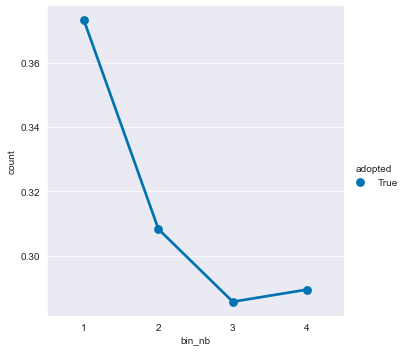

In [65]:
sns.catplot(x="bin_nb", y="count", hue="adopted", kind="point", data=adopted_count)

## User bin separation version

In [15]:
adopted_table = pd.read_csv("adopted_table.csv")

# Adding mainstream bins to adopted_table
song_bins = artist_data[["sng_id", "bin_nb"]].drop_duplicates().reset_index().drop(["index"], axis=1)
adopted_table = adopted_table.merge(song_bins[["sng_id", "bin_nb"]], left_on="sng_id", right_on="sng_id")

# Adding user_bins
adopted_table = adopted_table.merge(users_reco[["user_id", "u_bin_nb"]], left_on="user_id", right_on="user_id")

adopted_table

,user_id,sng_id,adopted,bin_nb,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,True,2,4
1,00877d231a1d10859eefd4288ecc493fd1ea3589,60842359,True,3,4
2,00877d231a1d10859eefd4288ecc493fd1ea3589,68437773,True,3,4
3,00877d231a1d10859eefd4288ecc493fd1ea3589,14233403,True,3,4
4,00877d231a1d10859eefd4288ecc493fd1ea3589,16571662,True,4,4
...,...,...,...,...,...
61003,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698278,True,4,3
61004,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698287,True,4,3
61005,b5c8e43539f4c498a2d58646b48bc91432d4f563,99976972,True,1,3
61006,e28bbf815d3ce6c4c601591c1a0155f573074134,2204604,True,4,1


In [67]:
adopted_count = adopted_table.groupby(["u_bin_nb", "bin_nb", "adopted"]).size().to_frame().reset_index()
adopted_count.columns = ["u_bin_nb", "bin_nb", "adopted", "count"]
adopted_count

,u_bin_nb,bin_nb,adopted,count
0,1,1,False,1426
1,1,1,True,67
2,1,2,False,2460
3,1,2,True,78
4,1,3,False,3379
5,1,3,True,78
6,1,4,False,3345
7,1,4,True,64
8,2,1,False,1380
9,2,1,True,392


In [68]:
# Normalization
means = adopted_count.groupby(["u_bin_nb", "bin_nb"]).sum().reset_index()

adopted_count["count"] = adopted_count["count"].astype(float)
for i, row in adopted_count.iterrows():
    adopted_count.at[i, "count"] /= means[(means["u_bin_nb"] == row["u_bin_nb"]) & (means["bin_nb"] == row["bin_nb"])]["count"]

# No need to keep org_to_rec
adopted_count = adopted_count[adopted_count["adopted"] == True]
adopted_count

,u_bin_nb,bin_nb,adopted,count
1,1,1,True,0.044876
3,1,2,True,0.030733
5,1,3,True,0.022563
7,1,4,True,0.018774
9,2,1,True,0.221219
11,2,2,True,0.120101
13,2,3,True,0.102651
15,2,4,True,0.114336
17,3,1,True,0.393559
19,3,2,True,0.337068


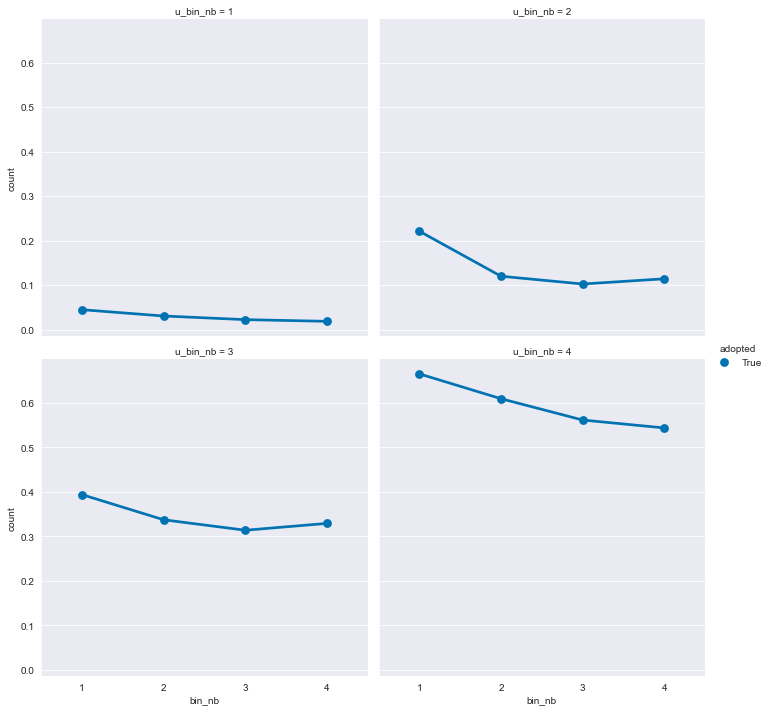

In [69]:
sns.catplot(x="bin_nb", y="count", hue="adopted", kind="point", col="u_bin_nb", col_wrap=2, data=adopted_count)

### Amount of re-listens after adoption

In [29]:
adopted_table

,user_id,sng_id,adopted,bin_nb,u_bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,True,2,4
1,00877d231a1d10859eefd4288ecc493fd1ea3589,60842359,True,3,4
2,00877d231a1d10859eefd4288ecc493fd1ea3589,68437773,True,3,4
3,00877d231a1d10859eefd4288ecc493fd1ea3589,14233403,True,3,4
4,00877d231a1d10859eefd4288ecc493fd1ea3589,16571662,True,4,4
...,...,...,...,...,...
61003,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698278,True,4,3
61004,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698287,True,4,3
61005,b5c8e43539f4c498a2d58646b48bc91432d4f563,99976972,True,1,3
61006,e28bbf815d3ce6c4c601591c1a0155f573074134,2204604,True,4,1


In [17]:
# Getting amount of organic re-listens for adopted songs for each user
adopted_amount = data_no_singletons[data_no_singletons["recommended"] == False].groupby(["user_id", "sng_id"]).size().to_frame().reset_index()
adopted_amount.columns = ["user_id", "sng_id", "amount"]
adopted_amount = adopted_table.merge(adopted_amount, on=["user_id", "sng_id"], how="left").dropna()
adopted_amount = adopted_amount[adopted_amount["adopted"] == True]

adopted_amount

,user_id,sng_id,adopted,bin_nb,u_bin_nb,amount
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,True,2,4,1.0
3,00877d231a1d10859eefd4288ecc493fd1ea3589,14233403,True,3,4,1.0
9,00877d231a1d10859eefd4288ecc493fd1ea3589,70697364,True,1,4,2.0
10,00877d231a1d10859eefd4288ecc493fd1ea3589,65672691,True,2,4,1.0
12,00877d231a1d10859eefd4288ecc493fd1ea3589,7337274,True,4,4,2.0
...,...,...,...,...,...,...
61003,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698278,True,4,3,6.0
61004,b5c8e43539f4c498a2d58646b48bc91432d4f563,77698287,True,4,3,3.0
61005,b5c8e43539f4c498a2d58646b48bc91432d4f563,99976972,True,1,3,1.0
61006,e28bbf815d3ce6c4c601591c1a0155f573074134,2204604,True,4,1,3.0


In [31]:
adopted_amount["amount"].sort_values()

0          1.0
36378      1.0
36371      1.0
36357      1.0
36341      1.0
         ...  
58599     94.0
58289     97.0
11017    105.0
7770     108.0
49877    119.0
Name: amount, Length: 13471, dtype: float64

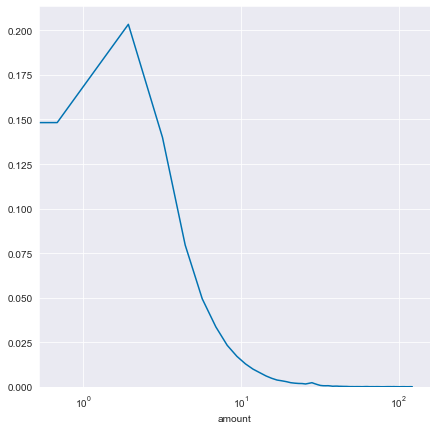

In [35]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", )
sns.distplot(adopted_amount["amount"], hist=False)

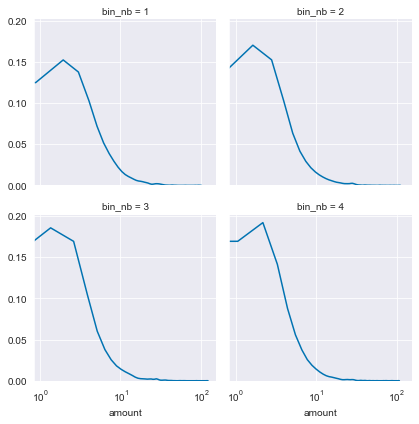

In [36]:
# Distribution per mainstream bin
# f, ax = plt.subplots(figsize=(7, 7))
g = sns.FacetGrid(adopted_amount, col="bin_nb", col_wrap=2)
g.set(xscale="log",)
g.map(sns.distplot, "amount", hist=False)

In [1]:
mean_relistens = adopted_amount.groupby(["bin_nb"])["amount"].mean().to_frame().reset_index()

ax = sns.catplot(x="bin_nb", y="amount", data=mean_relistens, kind="point")
ax.set(ylim=(0, 6))

NameError: name 'adopted_amount' is not defined